In [1]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
import re
from string import punctuation
import spacy

In [2]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

###  Text Processing

In [3]:
df = pd.read_csv("datasets/amazon_reviews.csv", sep=',')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [4]:
###############################
# Normalizing Case Folding
###############################
df["reviewText"] = df["reviewText"].astype("str").apply(lambda x: x.lower())

In [5]:
df["reviewText"]

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

In [6]:
###############################
# Punctuations
###############################
def remove_punctuations(text):
    new_text = []
    for word in text.split():  # metni kelimelere ayır
        w = re.sub(r'[^\w\s]', '', word)  # Noktalama işaretlerini kaldır
        w = re.sub(r'_', '', w)  # Alt çizgiyi kaldır
        new_text.append(w)  # Düzenlenen kelimeyi listeye ekle
    
    return " ".join(new_text)  # Listeyi string olarak birleştir

df["reviewText"] = df["reviewText"].apply(lambda x: remove_punctuations(x))

In [7]:
df["reviewText"]

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this 64gb micro sd ...
Name: reviewText, Length: 4915, dtype: object

In [8]:
###############################
# Numbers
###############################
df['reviewText'] = df['reviewText'].str.replace(r'\d', '', regex=True)

In [9]:
df["reviewText"]

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk gb class  to use with my...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this gb micro sd ca...
Name: reviewText, Length: 4915, dtype: object

In [10]:
###############################
# Stopwords
###############################
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
sw = stopwords.words("english")
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["reviewText"]

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected sprung higher capacity think ma...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

In [13]:
###############################
# Lemmatization
###############################
nltk.download("wordnet")
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
df["reviewText"]

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected sprung higher capacity think mad...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used extending capability samsung galaxy note ...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

In [15]:
###############################
# Lemmatization
###############################

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [16]:
words = ["Eating", "ate", "eat", "eats", "adjustable", "ability", "rafting", "meeting"]
for word in words:
    print(word, "|", stemmer.stem(word))

Eating | eat
ate | ate
eat | eat
eats | eat
adjustable | adjust
ability | abil
rafting | raft
meeting | meet


In [17]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("eating eats eat ate ability adjustable rafting meeting")

for token in doc:
    print(token, '|', token.lemma_)

eating | eat
eats | eat
eat | eat
ate | ate
ability | ability
adjustable | adjustable
rafting | rafting
meeting | meeting


In [18]:
##################################################
# 2. Text Visualization
##################################################


###############################
# Terim Frekanslarının Hesaplanması (Term-Frequency Inverse-Document Frequency TF-IDF)
###############################
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [19]:
tf

,index,0
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00
...,...,...
8996,unexpectedlythen,1.00
8997,extending,1.00
8998,alike,1.00
8999,stealwould,1.00


In [20]:
tf.columns = ["word", "tf"]

In [21]:
tf.sort_values(by="tf", ascending=False)

,word,tf
29,card,5537.00
14,work,2044.00
7,phone,1909.00
43,gb,1756.00
110,great,1446.00
...,...,...
4898,mhz,1.00
4897,enhances,1.00
4894,doesbefore,1.00
4892,phonejust,1.00


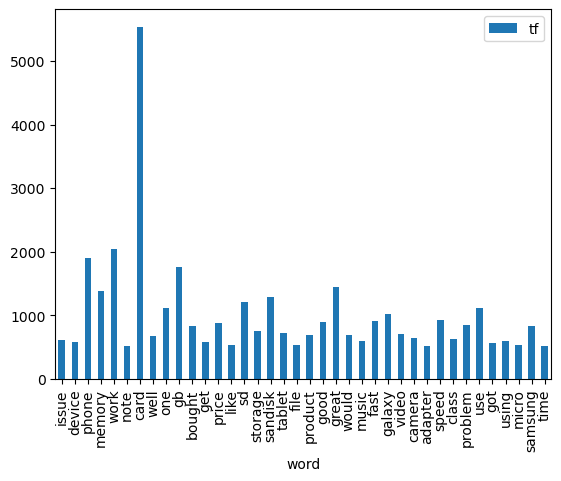

In [22]:
###############################
# Barplot
###############################
import matplotlib.pyplot as plt
tf[tf["tf"] > 500].plot.bar(x="word", y="tf")
plt.show()

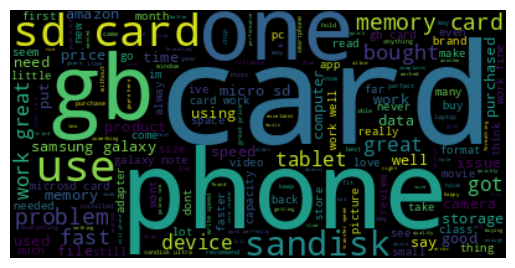

In [23]:
###############################
# Wordcloud
###############################
text = " ".join(w for w in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

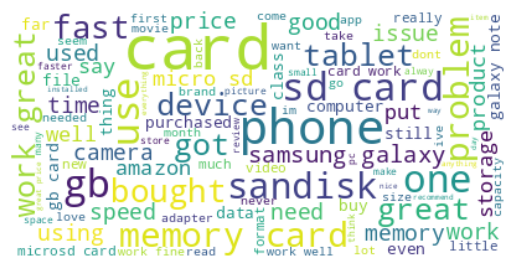

In [24]:
###############################
# Customizing Wordcloud through Constructor Parameters
###############################
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_whitebg.png")

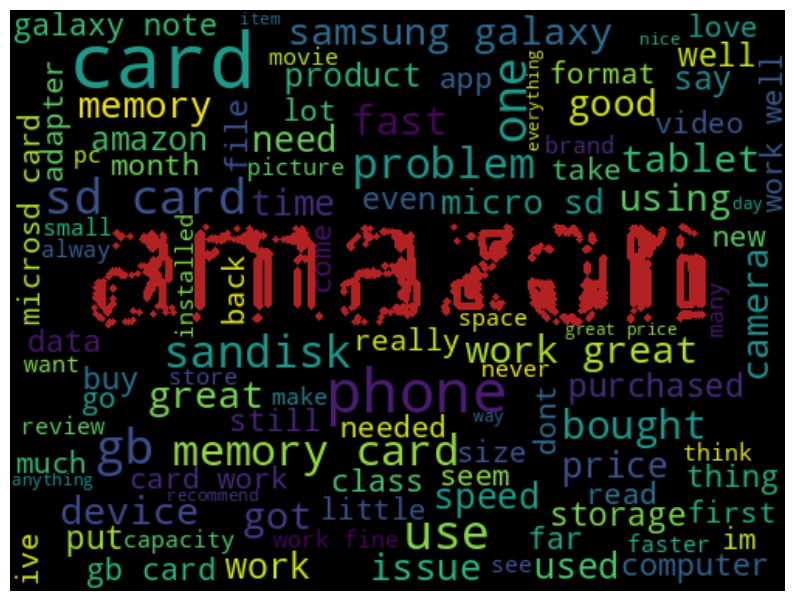

In [25]:
###############################
# Şablonlara Göre Wordcloud
###############################
file_path = "images/amazon_logo.jpg"
amazon_mask = np.asarray(Image.open(file_path))

wc = WordCloud(background_color="black",
                      max_words=100,
                      max_font_size=50,
                      mask=amazon_mask,
                      contour_width=5,
                      contour_color="firebrick"
                        )

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
##################################################
# 3. Sentiment Analysis
##################################################
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected sprung higher capacity think mad...
3    think worked greathad diff bran gb card went s...
4    bought retail packaging arrived legit orange e...
Name: reviewText, dtype: object

In [27]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

##### When Compound bigger than 0 it means that review is positive, when its smaller than 0 it means that review is negative

In [28]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [29]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [30]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
3    {'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...
4    {'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.099, 'neu': 0.589, 'pos': 0.312, 'co...
7    {'neg': 0.066, 'neu': 0.703, 'pos': 0.231, 'co...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
Name: reviewText, dtype: object

In [31]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)['compound'])

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.90
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [32]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [33]:
df[["reviewText", "polarity_score", "overall"]]

,reviewText,polarity_score,overall
0,issue,0.00,4.00
1,purchased device worked advertised never much ...,0.00,5.00
2,work expected sprung higher capacity think mad...,0.40,4.00
3,think worked greathad diff bran gb card went s...,0.65,5.00
4,bought retail packaging arrived legit orange e...,0.86,5.00
...,...,...,...
4910,bought sandisk gb class use htc inspire month ...,0.08,1.00
4911,used extending capability samsung galaxy note ...,0.18,5.00
4912,great card fast reliable come optional adapter...,0.85,5.00
4913,good amount space stuff want fit gopro say,0.69,5.00


### Anomali Tespiti Açıklaması

Sentiment analizi sırasında, metinlerin duygu polaritesini (`polarity_score`) pozitif olarak değerlendiren (yani 0'dan büyük) ancak ürünün genel değerlendirme puanının (`overall`) düşük olduğu (3'ten küçük) durumlar anomali olarak ele alınmıştır. Bu durumlar kullanıcı yorumlarının genel tonu ile değerlendirme puanının çeliştiğini gösterir.

Bu anomalilerin belirlenmesi, daha derin bir analiz yapmak ve olası veri tutarsızlıklarını veya model iyileştirme fırsatlarını belirlemek için kritik öneme sahiptir.

Aşağadaki kod, bu tür anomalileri filtrelemek ve görüntülemek için kullanılmıştır.


In [34]:
anomalies = df[(df["polarity_score"] > 0) & (df["overall"] < 3)]

In [35]:
anomalies

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
38,A1FKE13D77L3Y3,B007WTAJTO,Abraham Arturo Meza Marin,"[0, 0]",bougth micro sd card trubles got kingston tell...,1.00,Stop working after 1 year,1361232000,2013-02-19,657,0,0,0.92
108,A28CTDM7OP0RAR,B007WTAJTO,Alan,"[0, 0]",work actual rw speed mb even class marketed sa...,2.00,Painfully slow,1395705600,2014-03-25,258,0,0,0.42
123,A1UM44ILLZCEI1,B007WTAJTO,Aleksandar Milivojevic,"[1, 1]",bought gb version card use gopro hero black ed...,2.00,Didn't work out for me,1364947200,2013-03-04,644,1,1,0.88
143,A2T71JNR3C2DY1,B007WTAJTO,"Ali Etezadkhah ""Ali""","[0, 0]",old sandisk sd card still work thought new car...,1.00,Failed after 6 months,1371859200,2013-06-22,534,0,0,0.03
150,A87U7LY9OKZNY,B007WTAJTO,A. Liu,"[0, 0]",used galaxy note past month sudden longer writ...,2.00,Not writable after 16 months,1398988800,2014-02-05,306,0,0,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,AWNYBOENG7FJA,B007WTAJTO,wayne,"[0, 0]",bought two back gopro hero one amazon gift bbb...,2.00,Was it me or my camera,1389830400,2014-01-16,326,0,0,0.81
4847,A1UHLKBYQU4FV7,B007WTAJTO,"Woody ""woodman""","[1, 1]",purchased galaxie phone fit work much else say...,1.00,It stoppd working!,1359331200,2013-01-28,679,1,1,0.30
4867,A12P4PSWWXUYA0,B007WTAJTO,xplics,"[3, 5]",buyer beware card unreadable get go luck amazo...,1.00,Like others reviewed not that great of a card.,1348012800,2012-09-19,810,3,5,0.57
4892,A2SVI2JSSMA3PS,B007WTAJTO,Zackariah Zielieke,"[0, 1]",hellogreat card great price plenty speed worke...,1.00,It worked good until return policy was out,1388016000,2013-12-26,347,0,1,0.79


###############################
# 4. Feature Engineering
###############################

### Unsupervised Learning'den Supervised Learning'e Geçiş: Veri Etiketleme Süreci

Bu adımda, elimizdeki yorum verilerini etiketleyerek unsupervised learning yöntemlerinden supervised learning yöntemlerine geçiş yapılmaktadır. Bu süreç, verilerin belirli bir sınıfa (örneğin, pozitif veya negatif duygu durumu) ait olduğuna dair etiketlerin oluşturulmasını içerir. Bu etiketleme, gelecekte yeni yorumların hangi sınıfa ait olduğunu tahmin edebilecek bir sınıflandırma modeli geliştirmek için kullanılacaktır.

### Yöntem:
- **Sentiment Analysis (Duygu Analizi)**: Yorumların duygu polaritesini ölçmek için bir sentiment analiz modeli kullanılmıştır. 
- **Etiketleme Kriteri**: 
  - Eğer `compound` polarite skoru 0'dan büyükse, yorum "pozitif" (pos) olarak etiketlenmiştir.
  - Eğer `compound` polarite skoru 0'dan küçükse, yorum "negatif" (neg) olarak etiketlenmiştir.

Bu yöntemle, tüm veri kümesindeki yorumlar, pozitif ya da negatif olarak iki sınıfa ayrılarak etiketlenmiştir. Bu etiketler, gelecekte supervised learning modelleri için eğitim verisi olarak kullanılacaktır.


In [36]:
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [37]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [38]:
df[["reviewText", "overall", "sentiment_label"]]

,reviewText,overall,sentiment_label
0,issue,4.00,neg
1,purchased device worked advertised never much ...,5.00,neg
2,work expected sprung higher capacity think mad...,4.00,pos
3,think worked greathad diff bran gb card went s...,5.00,pos
4,bought retail packaging arrived legit orange e...,5.00,pos
...,...,...,...
4910,bought sandisk gb class use htc inspire month ...,1.00,pos
4911,used extending capability samsung galaxy note ...,5.00,pos
4912,great card fast reliable come optional adapter...,5.00,pos
4913,good amount space stuff want fit gopro say,5.00,pos


### Sentiment Analizinde Compound Limiti Belirleme Sorunu

Yapılan grup bazlı analiz sonucunda, negatif (`neg`) ve pozitif (`pos`) sentiment etiketlerinin `overall` ortalamalarının birbirine çok yakın olduğu görülmüştür (neg: 4.09, pos: 4.71). Bu durum, kullanılan `compound` limitinin doğru bir ayrım yapmadığını ve sentiment analizi sonuçlarının kullanıcı değerlendirme puanlarıyla yeterince uyumlu olmadığını göstermektedir.

**Sonuç:** Daha doğru bir sınıflandırma için `compound` limiti yeniden değerlendirilerek sentiment polariteleri arasındaki fark artırılmalıdır.


In [39]:
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [40]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0.4 else "neg")

In [41]:
df[["reviewText", "overall", "sentiment_label"]]

,reviewText,overall,sentiment_label
0,issue,4.00,neg
1,purchased device worked advertised never much ...,5.00,neg
2,work expected sprung higher capacity think mad...,4.00,pos
3,think worked greathad diff bran gb card went s...,5.00,pos
4,bought retail packaging arrived legit orange e...,5.00,pos
...,...,...,...
4910,bought sandisk gb class use htc inspire month ...,1.00,neg
4911,used extending capability samsung galaxy note ...,5.00,neg
4912,great card fast reliable come optional adapter...,5.00,pos
4913,good amount space stuff want fit gopro say,5.00,pos


In [42]:
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.28
pos   4.74
Name: overall, dtype: float64

In [52]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

y = df["sentiment_label"]
X = df["reviewText"]

# Count Vectors


#### Count Vectors: frekans temsiller
#### TF-IDF Vectors: normalize edilmiş frekans temsiller
#### Word Embeddings (Word2Vec, GloVe, BERT vs)

In [43]:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [44]:
# words
# kelimelerin nümerik temsilleri

# characters
# karakterlerin numerik temsilleri

# ngram
a = """Bu örneği anlaşılabilmesi için daha uzun bir metin üzerinden göstereceğim.
N-gram'lar birlikte kullanılan kelimelerin kombinasyolarını gösterir ve feature üretmek için kullanılır"""

TextBlob(a).ngrams(3)

[WordList(['Bu', 'örneği', 'anlaşılabilmesi']),
 WordList(['örneği', 'anlaşılabilmesi', 'için']),
 WordList(['anlaşılabilmesi', 'için', 'daha']),
 WordList(['için', 'daha', 'uzun']),
 WordList(['daha', 'uzun', 'bir']),
 WordList(['uzun', 'bir', 'metin']),
 WordList(['bir', 'metin', 'üzerinden']),
 WordList(['metin', 'üzerinden', 'göstereceğim']),
 WordList(['üzerinden', 'göstereceğim', "N-gram'lar"]),
 WordList(['göstereceğim', "N-gram'lar", 'birlikte']),
 WordList(["N-gram'lar", 'birlikte', 'kullanılan']),
 WordList(['birlikte', 'kullanılan', 'kelimelerin']),
 WordList(['kullanılan', 'kelimelerin', 'kombinasyolarını']),
 WordList(['kelimelerin', 'kombinasyolarını', 'gösterir']),
 WordList(['kombinasyolarını', 'gösterir', 've']),
 WordList(['gösterir', 've', 'feature']),
 WordList(['ve', 'feature', 'üretmek']),
 WordList(['feature', 'üretmek', 'için']),
 WordList(['üretmek', 'için', 'kullanılır'])]

In [45]:
###############################
# Count Vectors
###############################

from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [48]:
# word frekans
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [49]:
X_c.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [51]:
corpus_df = pd.DataFrame(
        X_c.toarray(),
        columns=vectorizer.get_feature_names_out(),
        index=corpus
)
corpus_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


In [57]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer="word", ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(X)
vectorizer2.get_feature_names_out()
X_n.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [59]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names_out()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)